In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── your cleaning steps ─────────────────────────
df = pd.read_csv('spiff_data.csv')

df.rename(columns={'gurkor':'cucumbers'}, inplace=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

mask = df.columns != 'day'
for col in df.columns[mask]:
  is_1000 = df[col] == 1000.0
  df.loc[is_1000, col] = df[col].shift(1)[is_1000]

#df.loc[:, mask] = df.loc[:, mask].replace(1000.0, np.nan)

#df['day'] = pd.to_datetime(df['day'], errors='coerce')
df['day'] = pd.to_datetime('2000-01-01') + pd.to_timedelta(df['day'] - 1, unit='D')
df.set_index('day', inplace=True)

# Drop the last 200 values, which we are supposed to extrapolate.
df = df[:-200]

# Create train and validation sets of df, using 200 values to validate
df_train = df[:-200]
df_validation = df[-200:]

# Interpolate the gaps in df_train (linear interpolation)
df_interpolated = df.interpolate(method='linear', limit_direction='both')

cucumbers_interpolated = df_interpolated['cucumbers']

#df['cucumbers'][:300].plot()
#cucumbers_interpolated[197:247].plot(color='orange')

# Create train and validation data
train_data = df_interpolated['slingshots']
true_future = df_validation['slingshots']
train_data.shape, true_future.shape

((5256,), (200,))

In [3]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.6 MB/s eta 0:00:00


In [4]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.3 MB/s eta 0:00:00


In [5]:
# Required for pmdarima (auto_arima) to work
!pip install numpy==1.24.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is 

In [7]:
df

,cucumbers,guitars,slingshots,stocks,sugar,water,tranquillity
day,,,,,,,
2000-01-01,6.154653,2.794285,2.136536,10.653684,3.324896,3.896149,7.755880
2000-01-02,6.189623,2.843068,2.113582,10.674465,3.355736,3.899915,7.781310
2000-01-03,6.168641,2.839644,2.116336,10.822372,3.336461,3.897404,7.886205
2000-01-04,6.156401,2.823384,2.096137,10.848804,3.288274,3.901170,7.848061
2000-01-05,6.124929,2.832798,2.099810,10.860731,3.303694,3.905355,7.883026
...,...,...,...,...,...,...,...
2014-05-18,13.790362,8.236738,6.451460,6.706903,2.972465,8.751953,11.767324
2014-05-19,13.798624,8.134064,6.406032,6.677940,2.960002,8.730038,11.830896
2014-05-20,13.800276,8.191484,6.444321,6.655631,2.837448,8.748910,12.129688


# Improved parameter tuning for ARMA + GARCH

## Baseline model

- Last known value? (Naive)

- Prophet
  - parameter tuning:

Parameter Tuning
Seasonality: Adjust daily_seasonality, weekly_seasonality, and yearly_seasonality based on the data’s characteristics. For financial prices, daily seasonality may be less relevant, but weekly or yearly patterns could exist.
Changepoints: Use changepoint_prior_scale to control trend flexibility (default is 0.05; lower for smoother trends, higher for more flexible trends).
Grid search: Test combinations of parameters (e.g., changepoint_prior_scale=[0.01, 0.05, 0.1], seasonality_prior_scale=[0.1, 1.0, 10.0]) using cross-validation.

Grid search:

from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(prophet_model, initial='4800 days', period='200 days', horizon='200 days')
df_metrics = performance_metrics(df_cv)
prophet_rmse = df_metrics['rmse'].mean()

- Validation:

Use rolling window cross-validation with RMSE, MAE, and MAPE.
Compare models using statistical tests and visualizations.

- Final Forecast:

Fit the best model (based on validation metrics) on the full 5,200 observations.
Generate 200-step-ahead forecasts with confidence intervals.

- Reporting:

Summarize results in a table comparing RMSE, MAE, and MAPE across models.
Provide plots of forecasts and confidence intervals.

In [2]:
train_data = df_interpolated['cucumbers']
true_future = df_validation['cucumbers']

train_data.isna().sum(), true_future.isna().sum()

(0, 0)

# BOX-COX TRANSFORMED DATA

In [8]:
from scipy.stats import boxcox
from scipy.stats import boxcox_normmax

# --- Guerrero lambda estimation ---
def guerrero_lambda(series, period=None):
    """Approximate Guerrero method for Box-Cox lambda selection."""
    series = series.dropna()
    if (series <= 0).any():
        raise ValueError("Guerrero requires all positive values")
    if period is None:
        period = max(10, len(series) // 10)  # heuristic fallback
    rolling_var = series.rolling(window=period, center=True, min_periods=1).var()
    mean_var_ratio = rolling_var.mean() / series.var()
    return max(-2, min(2, np.log(mean_var_ratio)))

# Containers
mle_transformed = {}
guerrero_transformed = {}
lambda_results = []

# Process each column
for col in df_interpolated.columns:
    if col == 'day':
        continue
    series = df_interpolated[col].dropna()

    if (series <= 0).any():
        print(f"Skipping {col} (contains non-positive values)")
        continue

    try:
        # Box-Cox MLE
        lambda_mle = boxcox_normmax(series, method='mle')
        transformed_mle = boxcox(series, lmbda=lambda_mle)

        # Guerrero lambda
        lambda_guerrero = guerrero_lambda(series)
        transformed_guerrero = boxcox(series, lmbda=lambda_guerrero)

        # Store
        mle_transformed[col] = transformed_mle
        guerrero_transformed[col] = transformed_guerrero
        lambda_results.append({
            "Instrument": col,
            "BoxCox_MLE_Lambda": round(lambda_mle, 6),
            "BoxCox_Guerrero_Lambda": round(lambda_guerrero, 6)
        })

        print(f"{col}: MLE λ = {lambda_mle:.4f}, Guerrero λ = {lambda_guerrero:.4f}")

    except Exception as e:
        print(f"Error processing {col}: {e}")

# Create result DataFrames
df_boxcox_mle = pd.DataFrame(mle_transformed)
df_boxcox_guerrero = pd.DataFrame(guerrero_transformed)
df_lambdas = pd.DataFrame(lambda_results)
guerrero_lambdas = df_lambdas['BoxCox_Guerrero_Lambda']

# fix index
series_names = ['cucumbers', 'guitars', 'slingshots', 'stocks', 'sugar', 'water', 'tranquillity']
guerrero_lambdas = pd.Series(guerrero_lambdas.values, index=series_names)

cucumbers: MLE λ = -1.0249, Guerrero λ = -2.0000
guitars: MLE λ = 0.5490, Guerrero λ = -1.4090
slingshots: MLE λ = -0.0540, Guerrero λ = -1.7675
stocks: MLE λ = -2.0141, Guerrero λ = -1.6483
sugar: MLE λ = 0.2617, Guerrero λ = -1.5525
water: MLE λ = -0.0249, Guerrero λ = -2.0000
tranquillity: MLE λ = -0.8244, Guerrero λ = -1.3472


In [9]:
guerrero_lambdas

,0
cucumbers,-2.000000
guitars,-1.409050
slingshots,-1.767472
stocks,-1.648266
sugar,-1.552516
water,-2.000000
tranquillity,-1.347191


# Rolling window with Monte Carlo ARIMA+GARCH with boxcox transform

In [23]:
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from collections import Counter
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.special import inv_boxcox

# Try this to remove some version warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

results = []
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=200)

for series_name in df_interpolated.columns:
    if series_name == 'day':
        continue

    # Prepare data
    train_data = df_interpolated[series_name][:-200]
    true_future = df_interpolated[series_name][-200:]

    train_data_boxcox = df_boxcox_guerrero[series_name][:-200]
    true_future_boxcox = df_boxcox_guerrero[series_name][-200:]

    # Lambda vals to inverse boxcox transform
    lambda_val = guerrero_lambdas[series_name]

    returns = np.log(train_data).diff().dropna()
    returns.index = pd.DatetimeIndex(returns.index).to_period('D').to_timestamp()
    returns_boxcox = np.log(train_data_boxcox / train_data_boxcox.shift(1)).dropna()
    returns_boxcox.index = pd.DatetimeIndex(returns_boxcox.index).to_period('D').to_timestamp()

    # Check variance of returns
    returns_var = np.var(returns)
    print(f"Series {series_name}, Variance of returns (original): {returns_var}")
    if returns_var < 1e-6:
        print(f"⚠️ Warning: Low variance (ORIGINAL) in returns for {series_name}, ARIMA may be unstable")

    returns_var_boxcox = np.var(returns_boxcox)
    print(f"Series {series_name}, Variance of returns (BoxCox): {returns_var_boxcox}")
    if returns_var_boxcox < 1e-6:
        print(f"⚠️ Warning: Low variance (BOXCOX) in returns for {series_name}, ARIMA may be unstable")

    # Compute scaling factor for Monte Carlo simulation
    variance_ratio = returns_var / returns_var_boxcox
    scaling_factor = np.sqrt(variance_ratio)

    # Lists to store metrics across folds
    fold_metrics = []


    # Rolling window CV
    for fold, (train_idx, test_idx) in enumerate(tscv.split(returns_boxcox)):
        train_returns_boxcox = returns_boxcox.iloc[train_idx]
        train_prices = train_data.iloc[train_idx]

        test_prices_boxcox = train_data_boxcox.iloc[test_idx]
        test_prices = train_data.iloc[test_idx]

        # Naive baseline model
        naive_forecast = np.full(200, train_data.iloc[train_idx[-1]])
        naive_rmse = np.sqrt(((naive_forecast - train_data.iloc[test_idx]) ** 2).mean())
        naive_mae = mean_absolute_error(train_data.iloc[test_idx], naive_forecast)
        # scale mape to match prophets percentage format
        naive_mape = mean_absolute_percentage_error(train_data.iloc[test_idx], naive_forecast)*100
        fold_metrics.append({'fold': fold, 'model': 'naive', 'rmse': naive_rmse, 'mae': naive_mae, 'mape': naive_mape})

        # Prophet
        prophet_df = pd.DataFrame({
            'ds': train_data.iloc[train_idx].index,
            'y': train_data.iloc[train_idx].values})

        # can try setting things like daily_seasonality=True, yearly_seasonality=True)
        # but right now just use default
        prophet_model = Prophet()
        prophet_model.fit(prophet_df)
        future = prophet_model.make_future_dataframe(periods=200, freq='D')
        prophet_forecast = prophet_model.predict(future)

        # Align forecast with test period
        test_dates = pd.to_datetime(train_data.iloc[test_idx].index).normalize()
        # Prophet returns full forecast; grab the last 200 matching future dates
        forecast_start = test_dates.min()
        forecast_end = test_dates.max()
        prophet_point_forecast = prophet_forecast[
            (prophet_forecast['ds'] >= forecast_start) & (prophet_forecast['ds'] <= forecast_end)
        ]['yhat'].values

        prophet_rmse = np.sqrt(((prophet_point_forecast - train_data.iloc[test_idx]) ** 2).mean())
        prophet_mae = mean_absolute_error(train_data.iloc[test_idx], prophet_point_forecast)
        prophet_mape = mean_absolute_percentage_error(train_data.iloc[test_idx], prophet_point_forecast) * 100
        fold_metrics.append({
            'fold': fold,
            'model': 'prophet',
            'rmse': prophet_rmse,
            'mae': prophet_mae,
            'mape': prophet_mape
        })

        # ARIMA order selection
        arima_model = auto_arima(train_returns_boxcox, seasonal=False, max_p=5, max_q=5, information_criterion='aic')
        arima_order = arima_model.order
        arima_result = ARIMA(train_returns_boxcox, order=arima_order).fit()

        # Ljung - Box and ARCH-LM tests
        residuals_boxcox = arima_result.resid.dropna()
        arch_needed = False
        if len(residuals_boxcox) < 10 or np.isclose(residuals_boxcox.var(), 0):
          print(f"Fold {fold}: Residuals too few / variance ~ 0 - skip tests.")
        else:
          max_lag = min(20, len(residuals_boxcox) // 5)
          lb_p = acorr_ljungbox(residuals_boxcox, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
          arch_p = het_arch(residuals_boxcox, nlags=min(10, max_lag))[1]
          print(f"Fold {fold}, Ljung-Box p={lb_p:.3f} (lag {max_lag})")
          print(f"Fold {fold}, ARCH-LM p={arch_p:.3f}")
          arch_needed = arch_p < 0.05

        # GARCH model

        # Default to zero if GARCH not needed
        garch_result = None
        var_garch = np.zeros(200)

        if arch_needed:
          garch_orders = [(1, 1), (1, 2), (2, 1), (2, 2), (3, 2), (2, 3), (3, 3)]
          best_garch_aic = float('inf')
          best_garch_order = None
          best_garch_result = None

          for garch_order in garch_orders:
              garch_model = arch_model(residuals_boxcox, vol='GARCH', p=garch_order[0], q=garch_order[1], rescale=False)
              garch_result = garch_model.fit(disp='off')

              if garch_result.aic < best_garch_aic:
                  best_garch_aic = garch_result.aic
                  best_garch_order = garch_order
                  best_garch_result = garch_result

          # Check GARCH stationarity (sum of alpha + beta < 1)
          alpha = best_garch_result.params.get('alpha[1]', 0)
          beta = best_garch_result.params.get('beta[1]', 0)
          if alpha + beta >= 1:
              print(f"⚠️ Warning: GARCH model may be non-stationary for {series_name}, fold {fold}, alpha + beta = {alpha + beta}")

          garch_forecast = best_garch_result.forecast(horizon=200, method='simulation')
          var_garch = garch_forecast.variance.values[-1, :]

        print(" -------- GARCH VARIANCE------ ")
        print(f"Fold {fold}, Max GARCH variance: {var_garch.max()}")

        # Monte Carlo Simulation for ARIMA+GARCH on Box-Cox data
        horizon = 200
        n_simulations = 100
        last_price = train_data.iloc[-1]

        # residuals from boxcox fit
        last_return = arima_result.resid.iloc[-1]

        phi = arima_result.params.get('ar.L1', 0)
        theta = [arima_result.params.get(f'ma.L{i}', 0) for i in range(1, arima_order[2] + 1)]
        mu = arima_result.params.get('const', 0)
        #eps_prev = [0.0] * arima_order[2] if arima_order[2] > 0 else []

        simulated_paths = np.zeros((n_simulations, horizon))
        for i in range(n_simulations):
            r_prev = last_return
            eps_prev = [0.0] * arima_order[2]
            sim_returns = []
            for t in range(horizon):
                std_dev = np.sqrt(var_garch[t]) * scaling_factor
                eps_t = np.random.normal(0, std_dev)

                ma_part = sum(theta[j] * eps_prev[j] for j in range(arima_order[2])) if arima_order[2] > 0 else 0

                r_t = mu + phi * r_prev + ma_part + eps_t
                sim_returns.append(r_t)

                r_prev = r_t
                eps_prev = [eps_t] + eps_prev[:-1]

            # Cumulative log returns and exponentiate to get back to Box-Cox scale
            sim_log_values = np.log(last_price) + np.cumsum(sim_returns)
            sim_values = np.exp(sim_log_values)
            simulated_paths[i, :] = sim_values

        # Inverse BoxCox transformation back to original scale
        # If test_prices_boxcox contains values that, when adjusted by
        # lambda, inv_boxcox may return NaN.

        arima_garch_forecast = simulated_paths.mean(axis=0)
        arima_garch_lower_bound = np.percentile(simulated_paths, 5, axis=0)
        arima_garch_upper_bound = np.percentile(simulated_paths, 95, axis=0)


        #print(f"Fold {fold}, Max simulated log prices: {sim_log_prices.max()}")
        print(f"Fold {fold}, Max simulated prices: {simulated_paths.max()}")
        print(f"Fold {fold}, Max point forecast: {arima_garch_forecast.max()}")

        # Metrics for this fold
        # fix these, should not be true future, use test_prices
        #rmse = np.sqrt(((point_forecast - test_prices) ** 2).mean())
        #mae = mean_absolute_error(test_prices, point_forecast)
        #mape = mean_absolute_percentage_error(test_prices, point_forecast)

        rmse = np.sqrt(((arima_garch_forecast - test_prices) ** 2).mean())
        mae = mean_absolute_error(test_prices, arima_garch_forecast)
        # Scale mape to match prophet's percentage format
        mape = mean_absolute_percentage_error(test_prices, arima_garch_forecast) * 100

        fold_metrics.append({
            'fold': fold,
            'model': 'arima_garch',
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'arima_order': arima_order,
            'garch_order': best_garch_order if arch_needed else None
        })

    # Average metrics across folds
    metrics_df = pd.DataFrame(fold_metrics)
    avg_metrics = metrics_df.groupby('model')[['rmse', 'mae', 'mape']].mean().reset_index()

    # Store CV results
    for _, row in avg_metrics.iterrows():
        result = {
            'series': series_name,
            'model': row['model'],
            'rmse': row['rmse'],
            'mae': row['mae'],
            'mape': row['mape']
        }
        if row['model'] == 'arima_garch':
            # Get most frequent orders across folds
            arima_orders = [str(m['arima_order']) for m in fold_metrics if m['model'] == 'arima_garch']
            garch_orders = [str(m['garch_order']) for m in fold_metrics if m['model'] == 'arima_garch']
            result['arima_order'] = eval(Counter(arima_orders).most_common(1)[0][0])
            result['garch_order'] = eval(Counter(garch_orders).most_common(1)[0][0])
        results.append(result)


    # ---------------  Final Forecasts ------------

    # Naive Baseline
    naive_final_forecast = np.full(200, train_data.iloc[-1])
    results.append({
        'series': series_name,
        'model': 'naive',
        'final_forecast': naive_final_forecast
    })

    # Prophet
    prophet_df = pd.DataFrame({'ds': train_data.index, 'y': train_data.values})
    # daily_seasonality=True
    prophet_model = Prophet()
    prophet_model.fit(prophet_df)
    future = prophet_model.make_future_dataframe(periods=200)
    prophet_forecast = prophet_model.predict(future)
    prophet_final_forecast = prophet_forecast['yhat'][-200:]
    prophet_lower_bound = prophet_forecast['yhat_lower'][-200:]
    prophet_upper_bound = prophet_forecast['yhat_upper'][-200:]
    results.append({
        'series': series_name,
        'model': 'prophet',
        'final_forecast': prophet_final_forecast,
        'lower_bound': prophet_lower_bound,
        'upper_bound': prophet_upper_bound
    })

    # ARIMA + GARCH (re-run auto_arima and GARCH AIC on full data)
    arima_model = auto_arima(returns_boxcox, seasonal=False, max_p=5, max_q=5, information_criterion='aic')
    arima_order = arima_model.order
    arima_result = ARIMA(returns_boxcox, order=arima_order).fit()
    residuals_boxcox = arima_result.resid.dropna()

    arch_needed = False
    if len(residuals_boxcox) < 10 or np.isclose(residuals_boxcox.var(), 0):
        print("⚠️ Final Forecast: Residuals too few / variance ≈ 0 – skip tests.")
    else:
        max_lag = min(20, len(residuals_boxcox)//5)
        lb_p = acorr_ljungbox(residuals_boxcox, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
        arch_p = het_arch(residuals_boxcox, nlags=min(10, max_lag))[1]
        print(f"⚠️ Final Forecast, Ljung-Box p={lb_p:.3f} (lag {max_lag})")
        print(f"⚠️ Final Forecast, ARCH-LM p={arch_p:.3f}")
        arch_needed = arch_p < 0.05

    garch_result = None
    var_garch = np.zeros(200)

    if arch_needed:
      garch_orders = [(1, 1), (1, 2), (2, 1), (2, 2), (3, 2), (2, 3), (3, 3)]
      best_garch_aic = float('inf')
      best_garch_order = None
      best_garch_result = None

      for garch_order in garch_orders:
          garch_model = arch_model(residuals_boxcox, vol='GARCH', p=garch_order[0], q=garch_order[1], rescale=False)
          garch_result = garch_model.fit(disp='off')
          if garch_result.aic < best_garch_aic:
              best_garch_aic = garch_result.aic
              best_garch_order = garch_order
              best_garch_result = garch_result

      garch_forecast = best_garch_result.forecast(horizon=200, method='simulation')
      var_garch = garch_forecast.variance.values[-1, :]

    # Monte Carlo Simulation for ARIMA+GARCH on Box-Cox data
    horizon = 200
    n_simulations = 100
    last_price = train_data.iloc[-1]
    last_return = arima_result.resid.iloc[-1]

    phi = arima_result.params.get('ar.L1', 0)
    theta = [arima_result.params.get(f'ma.L{i}', 0) for i in range(1, arima_order[2] + 1)]
    mu = arima_result.params.get('const', 0)
    #eps_prev = [0.0] * arima_order[2]


    simulated_paths = np.zeros((n_simulations, horizon))
    for i in range(n_simulations):

      r_prev = last_return  # Scalar for each simulation
      eps_prev = [0.0] * arima_order[2]  # History of shocks for this simulation

      sim_returns = []
      for t in range(horizon):
          std_dev = np.sqrt(var_garch[t]) * scaling_factor
          eps_t = np.random.normal(0, std_dev)  # Scalar shock for this simulation

          ma_part = sum(theta[j] * eps_prev[j] for j in range(arima_order[2])) if arima_order[2] > 0 else 0
          r_t = mu + phi * r_prev + ma_part + eps_t

          sim_returns.append(r_t)
          r_prev = r_t
          eps_prev = [eps_t] + eps_prev[:-1]

      # Cumulative log returns and exponentiate to get back to Box-Cox scale
      sim_log_values = np.log(last_price) + np.cumsum(sim_returns)
      sim_values = np.exp(sim_log_values)
      simulated_paths[i, :] = sim_values

    arima_garch_final_forecast = simulated_paths.mean(axis=0)
    arima_garch_lower_bound = np.percentile(simulated_paths, 5, axis=0)
    arima_garch_upper_bound = np.percentile(simulated_paths, 95, axis=0)

    results.append({
        'series': series_name,
        'model': 'arima_garch',
        'final_forecast': arima_garch_final_forecast,
        'lower_bound': arima_garch_lower_bound,
        'upper_bound': arima_garch_upper_bound,
        'arima_order': arima_order,
        'garch_order': best_garch_order if arch_needed else None
    })


# Summary of CV results
results_df = pd.DataFrame([r for r in results if 'rmse' in r])
print("Cross-Validation Results Summary:")
print(results_df[['series', 'model', 'rmse', 'mae', 'mape', 'arima_order', 'garch_order']])

# Final forecasts
forecast_df = pd.DataFrame([r for r in results if 'final_forecast' in r])
print("\nFinal Forecasts:")
print(forecast_df[['series', 'model', 'final_forecast', 'lower_bound', 'upper_bound']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/rj99vqbs.json


Series cucumbers, Variance of returns (original): 1.5827989170076743e-05
Series cucumbers, Variance of returns (BoxCox): 1.6334262058942945e-08
⚠️ Warning: Low variance (BOXCOX) in returns for cucumbers, ARIMA may be unstable


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/1iij0plr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82746', 'data', 'file=/tmp/tmp1pw36qt8/rj99vqbs.json', 'init=/tmp/tmp1pw36qt8/1iij0plr.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelbrn5xdqo/prophet_model-20250518092621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:26:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:26:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Fold 0, Ljung-Box p=0.002 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/2h2dgz4u.json


 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 3.289723118768693e-08
Fold 0, Max simulated prices: 16.30740050061408
Fold 0, Max point forecast: 13.749904742734804


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/8_hlh317.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34432', 'data', 'file=/tmp/tmp1pw36qt8/2h2dgz4u.json', 'init=/tmp/tmp1pw36qt8/8_hlh317.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model1m0m95d4/prophet_model-20250518092638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:26:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:26:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Fold 1, Ljung-Box p=0.002 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/lr6_q40l.json


 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 1.8158247922058466e-08
Fold 1, Max simulated prices: 15.75499323473313
Fold 1, Max point forecast: 13.800819998778868


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/5ymbikvg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15627', 'data', 'file=/tmp/tmp1pw36qt8/lr6_q40l.json', 'init=/tmp/tmp1pw36qt8/5ymbikvg.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelv_r67kt1/prophet_model-20250518092656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:26:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:27:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Fold 2, Ljung-Box p=0.001 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/p2sza43j.json


 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 1.6549924718366685e-08
Fold 2, Max simulated prices: 15.759620064890491
Fold 2, Max point forecast: 13.870708751445374


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/nc73b9hc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40463', 'data', 'file=/tmp/tmp1pw36qt8/p2sza43j.json', 'init=/tmp/tmp1pw36qt8/nc73b9hc.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelv3ns1i05/prophet_model-20250518092716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:27:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:27:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Fold 3, Ljung-Box p=0.000 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 1.5918522638540666e-08
Fold 3, Max simulated prices: 16.45327677845258
Fold 3, Max point forecast: 13.830348838743639


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/pz6vnow_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93251', 'data', 'file=/tmp/tmp1pw36qt8/4qiw46gh.json', 'init=/tmp/tmp1pw36qt8/pz6vnow_.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelrgwplfq2/prophet_model-20250518092738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:27:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:27:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Fold 4, Ljung-Box p=0.000 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 1.4823143248365307e-08
Fold 4, Max simulated prices: 15.541128162299822
Fold 4, Max point forecast: 13.766240363617209


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/05huw32k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32377', 'data', 'file=/tmp/tmp1pw36qt8/way757o_.json', 'init=/tmp/tmp1pw36qt8/05huw32k.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelvy057r4j/prophet_model-20250518092758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:27:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:28:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

⚠️ Final Forecast, Ljung-Box p=0.000 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

Series guitars, Variance of returns (original): 0.0002254188941233319
Series guitars, Variance of returns (BoxCox): 7.952456837536988e-06


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/uwu8wi6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36246', 'data', 'file=/tmp/tmp1pw36qt8/a9d7k5n1.json', 'init=/tmp/tmp1pw36qt8/uwu8wi6n.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modeln52k75gr/prophet_model-20250518092847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:28:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:28:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 0, Ljung-Box p=0.000 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 2.0016976871623218e-05
Fold 0, Max simulated prices: 15.70967479287307
Fold 0, Max point forecast: 7.348586380184702


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/pn4fiot2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/x8ajb2jm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7453', 'data', 'file=/tmp/tmp1pw36qt8/pn4fiot2.json', 'init=/tmp/tmp1pw36qt8/x8ajb2jm.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modeleyffeduy/prophet_model-20250518092919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:29:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:29:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

Fold 1, Ljung-Box p=0.000 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 9.443884443635716e-06
Fold 1, Max simulated prices: 11.354423254694611
Fold 1, Max point forecast: 7.339107418408363


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/a51k3cdm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58066', 'data', 'file=/tmp/tmp1pw36qt8/yv0_9uz4.json', 'init=/tmp/tmp1pw36qt8/a51k3cdm.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelco0vk1r4/prophet_model-20250518093000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:30:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:30:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 2, Ljung-Box p=0.000 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 8.419086939604894e-06
Fold 2, Max simulated prices: 13.909498924821312
Fold 2, Max point forecast: 7.351476844667267


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/fyv98mig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/a11dtr76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8388', 'data', 'file=/tmp/tmp1pw36qt8/fyv98mig.json', 'init=/tmp/tmp1pw36qt8/a11dtr76.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelan1o599z/prophet_model-20250518093026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:30:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:30:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

Fold 3, Ljung-Box p=0.000 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 7.461791238319291e-06


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/v8vh5__3.json


Fold 3, Max simulated prices: 10.759098953294357
Fold 3, Max point forecast: 7.184650347419034


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/k6nsmdnn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57651', 'data', 'file=/tmp/tmp1pw36qt8/v8vh5__3.json', 'init=/tmp/tmp1pw36qt8/k6nsmdnn.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelty68ny36/prophet_model-20250518093104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:31:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:31:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 4, Ljung-Box p=0.000 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 1.3332991799032628e-05
Fold 4, Max simulated prices: 12.225716212859023
Fold 4, Max point forecast: 7.0853034709904845


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/i2vduj45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/mmowvtot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60431', 'data', 'file=/tmp/tmp1pw36qt8/i2vduj45.json', 'init=/tmp/tmp1pw36qt8/mmowvtot.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model26tzeusi/prophet_model-20250518093202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:32:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:32:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no ass

⚠️ Final Forecast, Ljung-Box p=0.000 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

Series slingshots, Variance of returns (original): 0.00021955795572236217
Series slingshots, Variance of returns (BoxCox): 1.8771942148973628e-05


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/olhegz73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/tjgj3jny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53382', 'data', 'file=/tmp/tmp1pw36qt8/olhegz73.json', 'init=/tmp/tmp1pw36qt8/tjgj3jny.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelgqxongb1/prophet_model-20250518093248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:32:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:32:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels

Fold 0, Ljung-Box p=0.001 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 7.01965978478581e-05
Fold 0, Max simulated prices: 9.839485075457453
Fold 0, Max point forecast: 5.271704420060853


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/tj_xjfdu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/c0kdqcis.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68873', 'data', 'file=/tmp/tmp1pw36qt8/tj_xjfdu.json', 'init=/tmp/tmp1pw36qt8/c0kdqcis.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model0c4j9em1/prophet_model-20250518093303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:33:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:33:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

Fold 1, Ljung-Box p=0.034 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 3.2593880973839504e-05


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/qhejg47h.json


Fold 1, Max simulated prices: 10.457453943026163
Fold 1, Max point forecast: 5.493903710471061


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/lz3vy9ve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7400', 'data', 'file=/tmp/tmp1pw36qt8/qhejg47h.json', 'init=/tmp/tmp1pw36qt8/lz3vy9ve.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelq5a6j4cp/prophet_model-20250518093347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:33:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:33:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/

Fold 2, Ljung-Box p=0.036 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 1.825908559090583e-05


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/yxoyasow.json


Fold 2, Max simulated prices: 8.107843442523453
Fold 2, Max point forecast: 5.359462843229402


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/mbcca201.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42693', 'data', 'file=/tmp/tmp1pw36qt8/yxoyasow.json', 'init=/tmp/tmp1pw36qt8/mbcca201.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelb293228m/prophet_model-20250518093436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:34:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:34:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 3, Ljung-Box p=0.040 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 2.2868107311479647e-05
Fold 3, Max simulated prices: 10.159113392844707
Fold 3, Max point forecast: 5.425359901328009


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/b97_bwuc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88820', 'data', 'file=/tmp/tmp1pw36qt8/o19h_y5n.json', 'init=/tmp/tmp1pw36qt8/b97_bwuc.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model1eluo5p_/prophet_model-20250518093535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:35:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:35:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 4, Ljung-Box p=0.025 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 2.0710408391784433e-05


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fold 4, Max simulated prices: 8.547321477838471
Fold 4, Max point forecast: 5.375981685521646


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/0766eoxh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/gwcs267s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60594', 'data', 'file=/tmp/tmp1pw36qt8/0766eoxh.json', 'init=/tmp/tmp1pw36qt8/gwcs267s.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelwx5hvgfd/prophet_model-20250518093623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:36:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:36:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

⚠️ Final Forecast, Ljung-Box p=0.017 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

Series stocks, Variance of returns (original): 0.00021966421013982172
Series stocks, Variance of returns (BoxCox): 2.458398129421218e-06


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/97ge2dfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/9kadc1iu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27209', 'data', 'file=/tmp/tmp1pw36qt8/97ge2dfg.json', 'init=/tmp/tmp1pw36qt8/9kadc1iu.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelbi0spxs9/prophet_model-20250518093651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:36:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:36:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

Fold 0, Ljung-Box p=0.431 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 3.6741967237206916e-06
Fold 0, Max simulated prices: 10.197755969749393
Fold 0, Max point forecast: 5.286949925878319


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/g1ll0g0i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55264', 'data', 'file=/tmp/tmp1pw36qt8/a3tcj0sp.json', 'init=/tmp/tmp1pw36qt8/g1ll0g0i.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelxnxms95l/prophet_model-20250518093703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:37:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 1, Ljung-Box p=0.339 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/3plljgju.json


 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 3.6643561060365912e-06
Fold 1, Max simulated prices: 9.144324341408685
Fold 1, Max point forecast: 5.266847538437386


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/r26o872i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98110', 'data', 'file=/tmp/tmp1pw36qt8/3plljgju.json', 'init=/tmp/tmp1pw36qt8/r26o872i.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modeley9h996i/prophet_model-20250518093716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:37:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 2, Ljung-Box p=0.510 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
INFO:prophet:Disabling daily seasonality. Run pr

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 2.5604496694637295e-06
Fold 2, Max simulated prices: 8.078703918659597
Fold 2, Max point forecast: 5.248357508009031


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/3j47hefu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96018', 'data', 'file=/tmp/tmp1pw36qt8/c_yyj8rh.json', 'init=/tmp/tmp1pw36qt8/3j47hefu.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelnjnzzgm1/prophet_model-20250518093729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:37:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 3, Ljung-Box p=0.330 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 2.3851359930597326e-06
Fold 3, Max simulated prices: 7.39767191509017
Fold 3, Max point forecast: 5.065905998631843


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/ey9dr57x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68781', 'data', 'file=/tmp/tmp1pw36qt8/vkg629sk.json', 'init=/tmp/tmp1pw36qt8/ey9dr57x.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelcjrzaxf2/prophet_model-20250518093741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:37:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 4, Ljung-Box p=0.437 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 2.883200991069615e-06
Fold 4, Max simulated prices: 9.16590443694252
Fold 4, Max point forecast: 5.101342465472095


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/3v1m2c1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30516', 'data', 'file=/tmp/tmp1pw36qt8/kv8wl8xr.json', 'init=/tmp/tmp1pw36qt8/3v1m2c1_.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model1zxlw_w5/prophet_model-20250518093754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:37:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

⚠️ Final Forecast, Ljung-Box p=0.325 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

Series sugar, Variance of returns (original): 0.00023005582357194527
Series sugar, Variance of returns (BoxCox): 0.00017089639178231595


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/5n6cenrh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70251', 'data', 'file=/tmp/tmp1pw36qt8/jh7s0rct.json', 'init=/tmp/tmp1pw36qt8/5n6cenrh.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelq338txbw/prophet_model-20250518093808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:38:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:38:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 0, Ljung-Box p=0.011 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0019532258664853
Fold 0, Max simulated prices: 7.143730906863059
Fold 0, Max point forecast: 2.1027449241842056


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/00pw_kn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34362', 'data', 'file=/tmp/tmp1pw36qt8/00i1nyqe.json', 'init=/tmp/tmp1pw36qt8/00pw_kn_.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelwjv8jbjx/prophet_model-20250518093821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:38:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:38:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 1, Ljung-Box p=0.000 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.00019059448125256507


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/q627t_bp.json


Fold 1, Max simulated prices: 3.0684446619882793
Fold 1, Max point forecast: 1.9259740696392078


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/yo80ihz4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21253', 'data', 'file=/tmp/tmp1pw36qt8/q627t_bp.json', 'init=/tmp/tmp1pw36qt8/yo80ihz4.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelfnvd5o18/prophet_model-20250518093916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:39:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:39:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 2, Ljung-Box p=0.000 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.00016340362588291102
Fold 2, Max simulated prices: 3.0637978107702573
Fold 2, Max point forecast: 1.9085355764880676


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/5ljna3yj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55927', 'data', 'file=/tmp/tmp1pw36qt8/s47zsldm.json', 'init=/tmp/tmp1pw36qt8/5ljna3yj.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model3wx0giac/prophet_model-20250518094009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:40:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 3, Ljung-Box p=0.000 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.00017546767712903663
Fold 3, Max simulated prices: 2.995397928738243
Fold 3, Max point forecast: 1.935610114118461


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/1h36f6ai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/7ot7gsn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10047', 'data', 'file=/tmp/tmp1pw36qt8/1h36f6ai.json', 'init=/tmp/tmp1pw36qt8/7ot7gsn9.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model987h1gv0/prophet_model-20250518094041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:40:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

Fold 4, Ljung-Box p=0.000 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 0.000252798386546065
Fold 4, Max simulated prices: 3.2693952104530224
Fold 4, Max point forecast: 1.9100873799050706


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/stgv1p5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/453lb12n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59722', 'data', 'file=/tmp/tmp1pw36qt8/stgv1p5l.json', 'init=/tmp/tmp1pw36qt8/453lb12n.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model20fkeg0b/prophet_model-20250518094120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:41:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:41:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

⚠️ Final Forecast, Ljung-Box p=0.000 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

Series water, Variance of returns (original): 1.2326905302187694e-05
Series water, Variance of returns (BoxCox): 8.138860292978328e-08
⚠️ Warning: Low variance (BOXCOX) in returns for water, ARIMA may be unstable


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/810u7j8u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/bxip6d59.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80009', 'data', 'file=/tmp/tmp1pw36qt8/810u7j8u.json', 'init=/tmp/tmp1pw36qt8/bxip6d59.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelq4hv4zog/prophet_model-20250518094238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:42:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:42:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels

Fold 0, Ljung-Box p=0.000 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 1.1228835748567447e-07
Fold 0, Max simulated prices: 10.10355545609325
Fold 0, Max point forecast: 8.570561050331452


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/bidwl0rf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31709', 'data', 'file=/tmp/tmp1pw36qt8/nuzp2l6q.json', 'init=/tmp/tmp1pw36qt8/bidwl0rf.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model0tfif0ms/prophet_model-20250518094300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:43:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:43:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Fold 1, Ljung-Box p=0.000 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 8.654638367148877e-08
Fold 1, Max simulated prices: 9.642095505156748
Fold 1, Max point forecast: 8.571156362501947


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/8bg0370j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95393', 'data', 'file=/tmp/tmp1pw36qt8/08dtyh71.json', 'init=/tmp/tmp1pw36qt8/8bg0370j.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelxbb9ru8a/prophet_model-20250518094323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:43:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:43:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Fold 2, Ljung-Box p=0.000 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
INFO:prophet:Disabling daily seasonality. Run pr

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 7.984327238565273e-08
Fold 2, Max simulated prices: 9.369484744100655
Fold 2, Max point forecast: 8.547100722659883


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/kx0948sf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/uril8dab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80833', 'data', 'file=/tmp/tmp1pw36qt8/kx0948sf.json', 'init=/tmp/tmp1pw36qt8/uril8dab.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelwzc7gxyz/prophet_model-20250518094347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:43:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:43:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels

Fold 3, Ljung-Box p=0.000 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 7.855466843693414e-08
Fold 3, Max simulated prices: 9.240099777145453
Fold 3, Max point forecast: 8.551268220423303


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/9tio5_3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59852', 'data', 'file=/tmp/tmp1pw36qt8/eh5m34di.json', 'init=/tmp/tmp1pw36qt8/9tio5_3z.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model4rokzb0w/prophet_model-20250518094410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:44:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:44:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 4, Ljung-Box p=0.000 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 8.335265870967504e-08
Fold 4, Max simulated prices: 9.59262617366046
Fold 4, Max point forecast: 8.56941214471363


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/n3lcgole.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/mk018htk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75606', 'data', 'file=/tmp/tmp1pw36qt8/n3lcgole.json', 'init=/tmp/tmp1pw36qt8/mk018htk.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelfrxqc34x/prophet_model-20250518094437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:44:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:44:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels

⚠️ Final Forecast, Ljung-Box p=0.000 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

Series tranquillity, Variance of returns (original): 0.00015742639415925125
Series tranquillity, Variance of returns (BoxCox): 4.6461337504465356e-07
⚠️ Warning: Low variance (BOXCOX) in returns for tranquillity, ARIMA may be unstable


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/rwyr11em.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/t4d1_k8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99742', 'data', 'file=/tmp/tmp1pw36qt8/rwyr11em.json', 'init=/tmp/tmp1pw36qt8/t4d1_k8s.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelul55y9ow/prophet_model-20250518094506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:45:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:45:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

Fold 0, Ljung-Box p=0.719 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 4.617654082930449e-07
Fold 0, Max simulated prices: 22.79580660239931
Fold 0, Max point forecast: 12.676162972444017


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/c9pxm3ta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19805', 'data', 'file=/tmp/tmp1pw36qt8/lagjhxtu.json', 'init=/tmp/tmp1pw36qt8/c9pxm3ta.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model4qh30ho5/prophet_model-20250518094537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:45:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:45:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 1, Ljung-Box p=0.171 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 1.627533832349402e-06
Fold 1, Max simulated prices: 40.77511290275669
Fold 1, Max point forecast: 13.154552100519288


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/zscgt2qr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/0_z678zo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28519', 'data', 'file=/tmp/tmp1pw36qt8/zscgt2qr.json', 'init=/tmp/tmp1pw36qt8/0_z678zo.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelk79cap1l/prophet_model-20250518094626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:46:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:46:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

Fold 2, Ljung-Box p=0.148 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 6.715478574247792e-07
Fold 2, Max simulated prices: 33.64724978009765
Fold 2, Max point forecast: 12.502118101976986


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/malhdzj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90874', 'data', 'file=/tmp/tmp1pw36qt8/wfvk8s5r.json', 'init=/tmp/tmp1pw36qt8/malhdzj2.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modeljuz5bdqg/prophet_model-20250518094659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:46:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 3, Ljung-Box p=0.141 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 4.487171190399319e-07
Fold 3, Max simulated prices: 29.102715824922033
Fold 3, Max point forecast: 12.949517777300459


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/mdeskbw5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12621', 'data', 'file=/tmp/tmp1pw36qt8/rshxnzlg.json', 'init=/tmp/tmp1pw36qt8/mdeskbw5.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_model7_lw_s85/prophet_model-20250518094728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:47:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:47:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

Fold 4, Ljung-Box p=0.086 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 4.753246089833894e-07
Fold 4, Max simulated prices: 25.201337102544024
Fold 4, Max point forecast: 12.781308070995145


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1pw36qt8/okk1lznb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12064', 'data', 'file=/tmp/tmp1pw36qt8/7jqo_7i2.json', 'init=/tmp/tmp1pw36qt8/okk1lznb.json', 'output', 'file=/tmp/tmp1pw36qt8/prophet_modelmg11oixt/prophet_model-20250518094804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:48:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:48:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

⚠️ Final Forecast, Ljung-Box p=0.073 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

Cross-Validation Results Summary:
          series        model      rmse       mae       mape arima_order  \
0      cucumbers  arima_garch  1.701948  1.662299   0.144368   (0, 0, 0)   
1      cucumbers        naive  0.603771  0.527199   0.043276         NaN   
2      cucumbers      prophet  0.485922  0.440046   3.690486         NaN   
3        guitars  arima_garch  1.273881  1.179895   0.226975   (1, 0, 1)   
4        guitars        naive  0.734892  0.604169   0.108525         NaN   
5        guitars      prophet  1.623989  1.538905  28.450551         NaN   
6     slingshots  arima_garch  1.211476  1.139642   0.338465   (1, 0, 2)   
7     slingshots        naive  0.514113  0.450496   0.118512         NaN   
8     slingshots      prophet  1.196181  1.128936  30.149416         NaN   
9         stocks  arima_garch  0.460392  0.393157   0.081695   (0, 0, 0)   
10        stocks        naive  0.497413  0.422601   0.085209         NaN   
11        stocks      prophet  0.496900  0.435821   8.

In [24]:
results_df

,series,model,rmse,mae,mape,arima_order,garch_order
0,cucumbers,arima_garch,1.701948,1.662299,0.144368,"(0, 0, 0)","(2, 3)"
1,cucumbers,naive,0.603771,0.527199,0.043276,NaN,NaN
2,cucumbers,prophet,0.485922,0.440046,3.690486,NaN,NaN
3,guitars,arima_garch,1.273881,1.179895,0.226975,"(1, 0, 1)","(3, 2)"
4,guitars,naive,0.734892,0.604169,0.108525,NaN,NaN
5,guitars,prophet,1.623989,1.538905,28.450551,NaN,NaN
6,slingshots,arima_garch,1.211476,1.139642,0.338465,"(1, 0, 2)","(2, 2)"
7,slingshots,naive,0.514113,0.450496,0.118512,NaN,NaN
8,slingshots,prophet,1.196181,1.128936,30.149416,NaN,NaN
9,stocks,arima_garch,0.460392,0.393157,0.081695,"(0, 0, 0)","(3, 3)"


In [25]:
forecast_df

,series,model,final_forecast,lower_bound,upper_bound,arima_order,garch_order
0,cucumbers,naive,"[13.74113139411363, 13.74113139411363, 13.7411...",NaN,NaN,NaN,NaN
1,cucumbers,prophet,5056 13.649063 5057 13.647251 5058 13...,5056 13.418538 5057 13.433492 5058 13...,5056 13.871139 5057 13.878815 5058 13...,NaN,NaN
2,cucumbers,arima_garch,"[13.739648100004267, 13.741116235676063, 13.74...","[13.714274214660403, 13.700831822195415, 13.69...","[13.76850521243651, 13.776354674567637, 13.807...","(0, 0, 0)","(2, 3)"
3,guitars,naive,"[6.899867182411381, 6.899867182411381, 6.89986...",NaN,NaN,NaN,NaN
4,guitars,prophet,5056 6.998671 5057 7.009873 5058 7.01...,5056 6.406016 5057 6.392868 5058 6.38...,5056 7.601739 5057 7.633630 5058 7.59...,NaN,NaN
5,guitars,arima_garch,"[6.913719626587814, 6.91091561040104, 6.913712...","[6.837116650372571, 6.800035275832925, 6.79224...","[6.986651064698858, 7.026194282412247, 7.04444...","(1, 0, 1)","(2, 2)"
6,slingshots,naive,"[5.221729597219595, 5.221729597219595, 5.22172...",NaN,NaN,NaN,NaN
7,slingshots,prophet,5056 5.398996 5057 5.404137 5058 5.40...,5056 5.035081 5057 5.067449 5058 5.05...,5056 5.735557 5057 5.743609 5058 5.72...,NaN,NaN
8,slingshots,arima_garch,"[5.2193368953234165, 5.2197507855583964, 5.214...","[5.1764384603881, 5.1629602419989515, 5.144544...","[5.263780696035562, 5.280803196499825, 5.27313...","(1, 0, 2)","(2, 2)"
9,stocks,naive,"[5.058071015061273, 5.058071015061273, 5.05807...",NaN,NaN,NaN,NaN


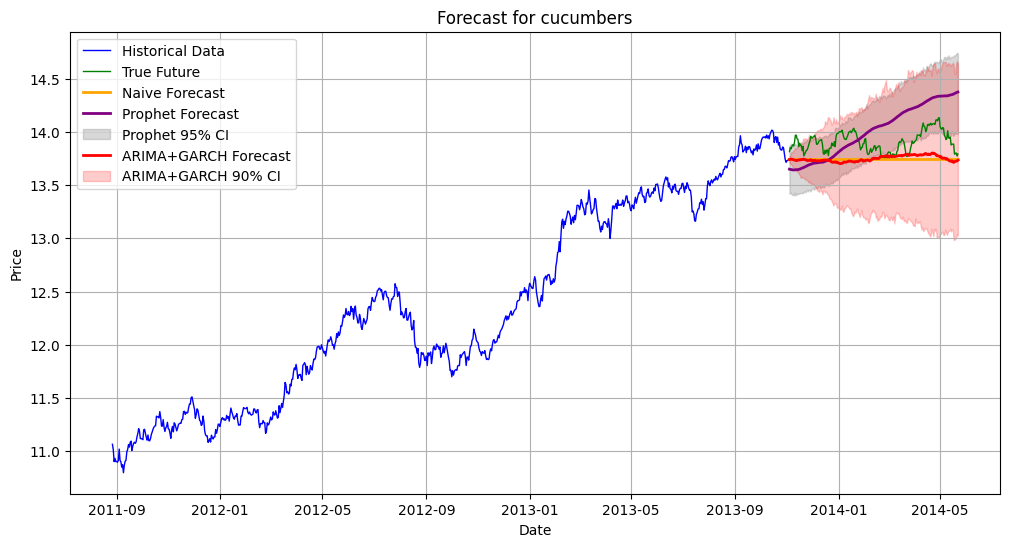

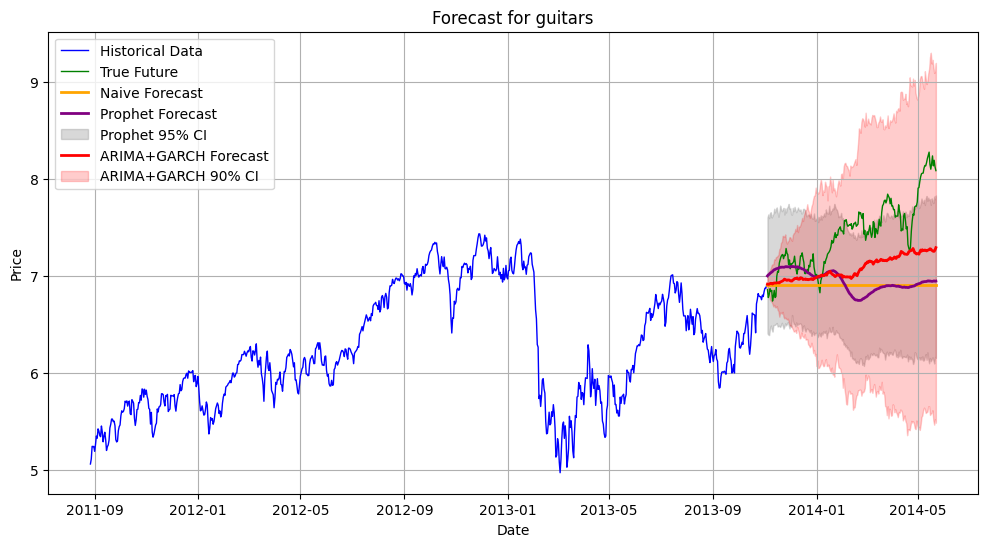

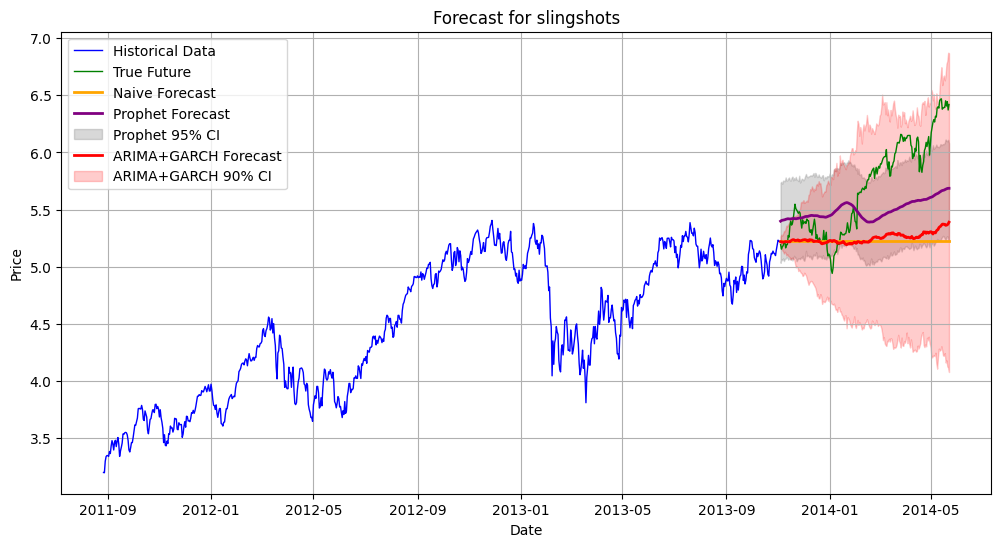

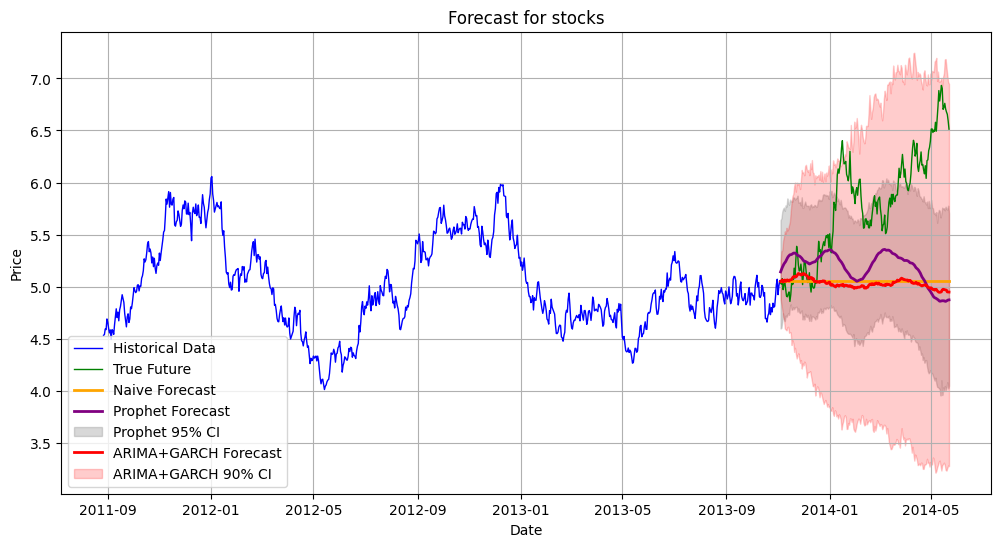

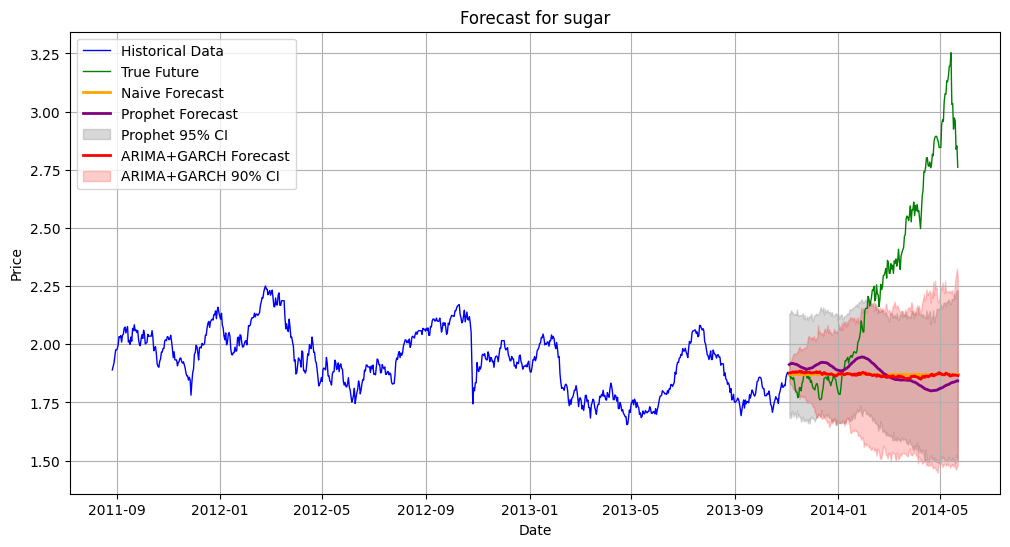

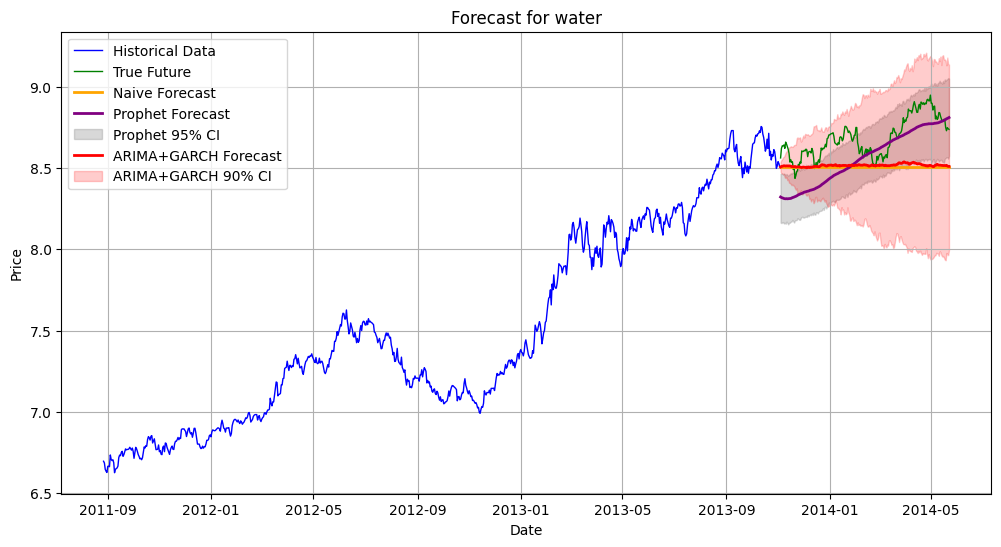

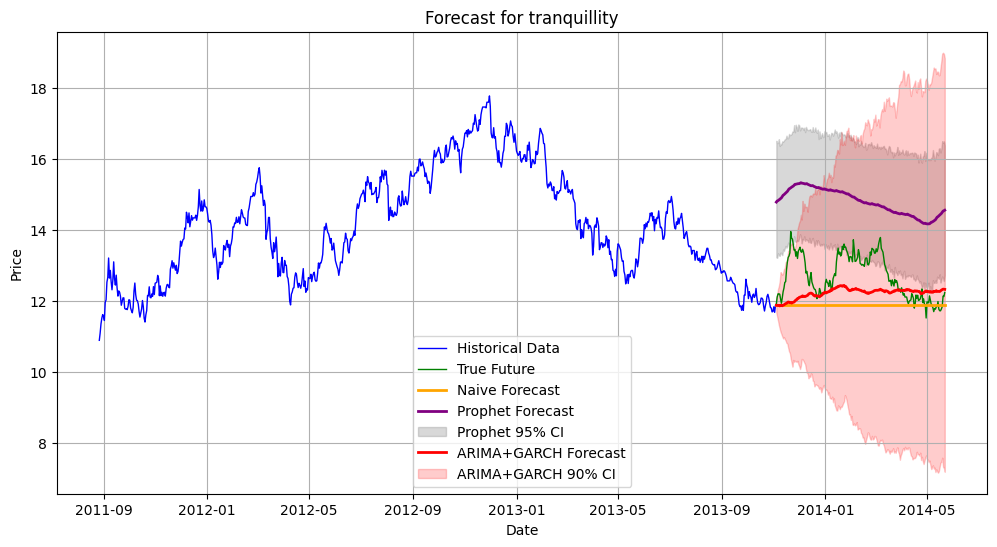

In [26]:
# Plot final forecasts with confidence intervals
for series_name in df_interpolated.columns:
    if series_name == 'day':
        continue

    # Extract historical and true future data
    train_data = df_interpolated[series_name][:-200]
    true_future = df_interpolated[series_name][-200:]

    # Generate dates for the forecast period
    last_train_date = train_data.index[-1]
    forecast_dates = pd.date_range(start=last_train_date + pd.Timedelta(days=1), periods=200, freq='D')

    # Extract forecasts for this series
    series_results = [r for r in results if r['series'] == series_name and 'final_forecast' in r]

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot historical data (last 800 points)
    plt.plot(train_data[-800:].index, train_data[-800:], label='Historical Data', color='blue', linewidth=1)

    # Plot true future data
    plt.plot(true_future.index, true_future, label='True Future', color='green', linewidth=1)

    # Plot forecasts for each model
    for result in series_results:
        model = result['model']
        forecast = result['final_forecast']

        if model == 'naive':
            plt.plot(forecast_dates, forecast, label='Naive Forecast', color='orange', linewidth=2)
        elif model == 'prophet':
            plt.plot(forecast_dates, forecast, label='Prophet Forecast', color='purple', linewidth=2)
            lower_bound = result['lower_bound']
            upper_bound = result['upper_bound']
            plt.fill_between(forecast_dates, lower_bound, upper_bound, color='gray', alpha=0.3, label='Prophet 95% CI')
        elif model == 'arima_garch':
            plt.plot(forecast_dates, forecast, label='ARIMA+GARCH Forecast', color='red', linewidth=2)
            lower_bound = result['lower_bound']
            upper_bound = result['upper_bound']
            plt.fill_between(forecast_dates, lower_bound, upper_bound, color='red', alpha=0.2, label='ARIMA+GARCH 90% CI')

    # Customize the plot
    plt.title(f'Forecast for {series_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

## Rolling window with Monte Carlo, ARIMA+GARCH

In [29]:
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from collections import Counter
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# Suppress library version warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

results = []
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=200)

for series_name in df_interpolated.columns:
    if series_name == 'day':
        continue

    # Prepare data
    train_data = df_interpolated[series_name][:-200]
    true_future = df_interpolated[series_name][-200:]

    returns = np.log(train_data).diff().dropna()
    returns.index = pd.DatetimeIndex(returns.index).to_period('D').to_timestamp()

    # Check variance of returns
    returns_var = np.var(returns)
    print(f"Series {series_name}, Variance of returns: {returns_var}")
    if returns_var < 1e-6:
        print(f"⚠️ Warning: Low variance in returns for {series_name}, ARIMA may be unstable")

    # Lists to store metrics across folds
    fold_metrics = []

    # Rolling window CV
    for fold, (train_idx, test_idx) in enumerate(tscv.split(returns)):
        train_returns = returns.iloc[train_idx]
        train_prices = train_data.iloc[train_idx]
        test_prices = train_data.iloc[test_idx]

        # Naive baseline model
        naive_forecast = np.full(200, train_prices.iloc[-1])
        naive_rmse = np.sqrt(((naive_forecast - test_prices) ** 2).mean())
        naive_mae = mean_absolute_error(test_prices, naive_forecast)
        naive_mape = mean_absolute_percentage_error(test_prices, naive_forecast)
        fold_metrics.append({'fold': fold, 'model': 'naive', 'rmse': naive_rmse, 'mae': naive_mae, 'mape': naive_mape})

        # Prophet
        prophet_df = pd.DataFrame({
            'ds': train_prices.index,
            'y': train_prices.values})

        # can try setting things like daily_seasonality=True, yearly_seasonality=True)
        # but right now just use default
        prophet_model = Prophet(daily_seasonality=True)
        prophet_model.fit(prophet_df)
        future = prophet_model.make_future_dataframe(periods=200, freq='D')
        prophet_forecast = prophet_model.predict(future)

        # Align forecast with test period
        #test_dates = pd.to_datetime(test_prices.index)
        #prophet_point_forecast = prophet_forecast['yhat'][-200:]
        # Ensure date format matches Prophet's forecast format
        test_dates = pd.to_datetime(test_prices.index).normalize()

        # Prophet returns full forecast; grab the last 200 matching future dates
        forecast_start = test_dates.min()
        forecast_end = test_dates.max()
        prophet_point_forecast = prophet_forecast[
            (prophet_forecast['ds'] >= forecast_start) & (prophet_forecast['ds'] <= forecast_end)
        ]['yhat'].values

        # Fallback if misalignment persists
        if len(prophet_point_forecast) != 200:
            print(f"⚠️ ⚠️ ⚠️ ⚠️ ⚠️ Prophet forecast misalignment in fold {fold} for {series_name}")
            #prophet_point_forecast = np.full(200, train_prices.iloc[-1])  # fallback to naive


        prophet_rmse = np.sqrt(((prophet_point_forecast - test_prices) ** 2).mean())
        prophet_mae = mean_absolute_error(test_prices, prophet_point_forecast)
        prophet_mape = mean_absolute_percentage_error(test_prices, prophet_point_forecast) * 100
        fold_metrics.append({
            'fold': fold,
            'model': 'prophet',
            'rmse': prophet_rmse,
            'mae': prophet_mae,
            'mape': prophet_mape
        })

        # ARIMA order selection
        # maybe get p and q to start_p = 1, start_q = 1 to avoid zero coefficients
        arima_model = auto_arima(train_returns, seasonal=False, max_p=5, max_q=5, information_criterion='aic')
        arima_order = arima_model.order
        arima_result = ARIMA(train_returns, order=arima_order).fit()

        # Ljung - Box and ARCH-LM tests
        residuals = arima_result.resid.dropna()
        arch_needed = False
        if len(residuals) < 10 or np.isclose(residuals.var(), 0):
          print(f"Fold {fold}: Residuals too few / variance ~ 0 - skip tests.")
        else:
          max_lag = min(20, len(residuals) // 5)
          lb_p = acorr_ljungbox(residuals, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
          arch_p = het_arch(residuals, nlags=min(10, max_lag))[1]
          print(f"Fold {fold}, Ljung-Box p={lb_p:.3f} (lag {max_lag})")
          print(f"Fold {fold}, ARCH-LM p={arch_p:.3f}")
          arch_needed = arch_p < 0.05

        # GARCH model

        # Default to zero if GARCH not needed
        garch_result = None
        var_garch = np.zeros(200)

        if arch_needed:
          garch_orders = [(1, 1), (1, 2), (2, 1), (2, 2), (3, 2), (2, 3), (3, 3)]
          best_garch_aic = float('inf')
          best_garch_order = None
          best_garch_result = None

          for garch_order in garch_orders:
              garch_model = arch_model(residuals, vol='GARCH', p=garch_order[0], q=garch_order[1], rescale=False)
              garch_result = garch_model.fit(disp='off')

              if garch_result.aic < best_garch_aic:
                  best_garch_aic = garch_result.aic
                  best_garch_order = garch_order
                  best_garch_result = garch_result

          # Check GARCH stationarity (sum of alpha + beta < 1)
          alpha = best_garch_result.params.get('alpha[1]', 0)
          beta = best_garch_result.params.get('beta[1]', 0)
          if alpha + beta >= 1:
              print(f"⚠️ Warning: GARCH model may be non-stationary for {series_name}, fold {fold}, alpha + beta = {alpha + beta}")

          garch_forecast = best_garch_result.forecast(horizon=200, method='simulation')
          var_garch = garch_forecast.variance.values[-1, :]

        print(" -------- GARCH VARIANCE------ ")
        print(f"Fold {fold}, Max GARCH variance: {var_garch.max()}")

        # Forecasting
        horizon = 200
        n_simulations = 100
        last_log_price = np.log(train_prices.iloc[-1])
        last_return = arima_result.resid.iloc[-1]

        phi = arima_result.params.get('ar.L1', 0)
        theta = [arima_result.params.get(f'ma.L{i}', 0) for i in range(1, arima_order[2] + 1)]
        mu = arima_result.params.get('const', 0)
        eps_prev = [0.0] * arima_order[2] if arima_order[2] > 0 else []

        simulated_paths = np.zeros((n_simulations, horizon))
        for i in range(n_simulations):
            r_prev = last_return
            eps_hist = eps_prev.copy()
            sim_returns = []
            for t in range(horizon):
                std_dev = np.sqrt(var_garch[t] + 1e-8)
                eps_t = np.random.normal(0, std_dev)

                ma_part = sum(theta[j] * eps_hist[j] for j in range(len(theta))) if theta else 0

                r_t = mu + phi * r_prev + ma_part + eps_t

                sim_returns.append(r_t)
                r_prev = r_t
                eps_hist = [eps_t] + eps_hist[:-1]
            sim_log_prices = last_log_price + np.cumsum(sim_returns)
            simulated_paths[i, :] = np.exp(sim_log_prices)

        print(f"Fold {fold}, Max simulated log prices: {sim_log_prices.max()}")
        print(f"Fold {fold}, Max simulated prices: {simulated_paths.max()}")
        point_forecast = simulated_paths.mean(axis=0)
        print(f"Fold {fold}, Max point forecast: {point_forecast.max()}")

        # Metrics for this fold
        # fix these, should not be true future, use test_prices
        rmse = np.sqrt(((point_forecast - test_prices) ** 2).mean())
        mae = mean_absolute_error(test_prices, point_forecast)
        mape = mean_absolute_percentage_error(test_prices, point_forecast)

        fold_metrics.append({
            'fold': fold,
            'model': 'arima_garch',
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'arima_order': arima_order,
            'garch_order': best_garch_order if arch_needed else None
        })

    # Average metrics across folds
    metrics_df = pd.DataFrame(fold_metrics)
    avg_metrics = metrics_df.groupby('model')[['rmse', 'mae', 'mape']].mean().reset_index()

    # Store CV results
    for _, row in avg_metrics.iterrows():
        result = {
            'series': series_name,
            'model': row['model'],
            'rmse': row['rmse'],
            'mae': row['mae'],
            'mape': row['mape']
        }
        if row['model'] == 'arima_garch':
            # Get most frequent orders across folds
            arima_orders = [str(m['arima_order']) for m in fold_metrics if m['model'] == 'arima_garch']
            garch_orders = [str(m['garch_order']) for m in fold_metrics if m['model'] == 'arima_garch']
            result['arima_order'] = eval(Counter(arima_orders).most_common(1)[0][0])
            result['garch_order'] = eval(Counter(garch_orders).most_common(1)[0][0])
        results.append(result)


    # ---------------  Final Forecasts ------------

    # Naive Baseline
    naive_final_forecast = np.full(200, train_data.iloc[-1])
    results.append({
        'series': series_name,
        'model': 'naive',
        'final_forecast': naive_final_forecast
    })

    # Prophet
    prophet_df = pd.DataFrame({'ds': train_data.index, 'y': train_data.values})
    prophet_model = Prophet(daily_seasonality=True)
    prophet_model.fit(prophet_df)
    future = prophet_model.make_future_dataframe(periods=200)
    prophet_forecast = prophet_model.predict(future)
    prophet_final_forecast = prophet_forecast['yhat'][-200:]
    prophet_lower_bound = prophet_forecast['yhat_lower'][-200:]
    prophet_upper_bound = prophet_forecast['yhat_upper'][-200:]
    results.append({
        'series': series_name,
        'model': 'prophet',
        'final_forecast': prophet_final_forecast,
        'lower_bound': prophet_lower_bound,
        'upper_bound': prophet_upper_bound
    })

    # ARIMA + GARCH (re-run auto_arima and GARCH AIC on full data)
    arima_model = auto_arima(returns, seasonal=False, max_p=5, max_q=5, information_criterion='aic')
    arima_order = arima_model.order
    arima_result = ARIMA(returns, order=arima_order).fit()
    residuals = arima_result.resid.dropna()

    arch_needed = False
    if len(residuals) < 10 or np.isclose(residuals.var(), 0):
        print("Final Forecast: Residuals too few / variance ≈ 0 – skip tests.")
    else:
        max_lag = min(20, len(residuals)//5)
        lb_p = acorr_ljungbox(residuals, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
        arch_p = het_arch(residuals, nlags=min(10, max_lag))[1]
        print(f"Final Forecast, Ljung-Box p={lb_p:.3f} (lag {max_lag})")
        print(f"Final Forecast, ARCH-LM p={arch_p:.3f}")
        arch_needed = arch_p < 0.05

    garch_result = None
    var_garch = np.zeros(200)

    if arch_needed:
      garch_orders = [(1, 1), (1, 2), (2, 1), (2, 2)]
      best_garch_aic = float('inf')
      best_garch_order = None
      best_garch_result = None

      for garch_order in garch_orders:
          garch_model = arch_model(residuals, vol='GARCH', p=garch_order[0], q=garch_order[1], rescale=False)
          garch_result = garch_model.fit(disp='off')
          if garch_result.aic < best_garch_aic:
              best_garch_aic = garch_result.aic
              best_garch_order = garch_order
              best_garch_result = garch_result

      garch_forecast = best_garch_result.forecast(horizon=200, method='simulation')
      var_garch = garch_forecast.variance.values[-1, :]

    horizon = 200
    n_simulations = 100
    last_log_price = np.log(train_data.iloc[-1])
    last_return = arima_result.resid.iloc[-1]

    phi = arima_result.params.get('ar.L1', 0)
    theta = [arima_result.params.get(f'ma.L{i}', 0) for i in range(1, arima_order[2] + 1)]
    mu = arima_result.params.get('const', 0)
    eps_prev = [0.0] * arima_order[2]


    simulated_paths = np.zeros((n_simulations, horizon))
    for i in range(n_simulations):

      r_prev = last_return  # Scalar for each simulation
      eps_prev = [0.0] * arima_order[2]  # History of shocks for this simulation
      sim_returns = []

      for t in range(horizon):
          std_dev = np.sqrt(var_garch[t])
          eps_t = np.random.normal(0, std_dev)  # Scalar shock for this simulation
          ma_part = sum(theta[j] * eps_prev[j] for j in range(arima_order[2])) if arima_order[2] > 0 else 0
          r_t = mu + phi * r_prev + ma_part + eps_t
          sim_returns.append(r_t)
          r_prev = r_t
          eps_prev = [eps_t] + eps_prev[:-1]

      sim_log_prices = last_log_price + np.cumsum(sim_returns)
      simulated_paths[i, :] = np.exp(sim_log_prices)

    #sim_log_prices = last_log_price + np.cumsum(simulated_paths, axis=1)
    arima_garch_final_forecast = simulated_paths.mean(axis=0)
    arima_garch_lower_bound = np.percentile(simulated_paths, 5, axis=0)
    arima_garch_upper_bound = np.percentile(simulated_paths, 95, axis=0)
    results.append({
        'series': series_name,
        'model': 'arima_garch',
        'final_forecast': arima_garch_final_forecast,
        'lower_bound': arima_garch_lower_bound,
        'upper_bound': arima_garch_upper_bound,
        'arima_order': arima_order,
        'garch_order': best_garch_order if arch_needed else None
    })


# Summary of CV results
results_df = pd.DataFrame([r for r in results if 'rmse' in r])
print("Cross-Validation Results Summary:")
print(results_df[['series', 'model', 'rmse', 'mae', 'mape', 'arima_order', 'garch_order']])

# Final forecasts
forecast_df = pd.DataFrame([r for r in results if 'final_forecast' in r])
print("\nFinal Forecasts:")
print(forecast_df[['series', 'model', 'final_forecast', 'lower_bound', 'upper_bound']])

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/oauurm_g.json


Series cucumbers, Variance of returns: 1.5827989170076743e-05


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/gf2kp2g6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77466', 'data', 'file=/tmp/tmpqkbue6sw/oauurm_g.json', 'init=/tmp/tmpqkbue6sw/gf2kp2g6.json', 'output', 'file=/tmp/tmpqkbue6sw/prophet_modelzdcj9zz6/prophet_model-20250517225907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero

Fold 0, Ljung-Box p=0.445 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 7.760996322736866e-05
Fold 0, Max simulated log prices: 2.376949853495631
Fold 0, Max simulated prices: 13.36007712072607
Fold 0, Max point forecast: 11.0450525103204


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/3ufl8um_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10562', 'data', 'file=/tmp/tmpqkbue6sw/m005kwky.json', 'init=/tmp/tmpqkbue6sw/3ufl8um_.json', 'output', 'file=/tmp/tmpqkbue6sw/prophet_model8612bn3u/prophet_model-20250517225953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1, Ljung-Box p=0.070 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 2.985629168612419e-05
Fold 1, Max simulated log prices: 2.447674208706694
Fold 1, Max simulated prices: 14.19115336285664
Fold 1, Max point forecast: 11.379952017285365


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/921dz3lh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64310', 'data', 'file=/tmp/tmpqkbue6sw/70mn54zv.json', 'init=/tmp/tmpqkbue6sw/921dz3lh.json', 'output', 'file=/tmp/tmpqkbue6sw/prophet_modelmb309sea/prophet_model-20250517230008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:00:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:00:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 2, Ljung-Box p=0.124 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/4l2lrm5h.json


 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 1.678113308954464e-05
Fold 2, Max simulated log prices: 2.5677502996746364
Fold 2, Max simulated prices: 13.55634910403556
Fold 2, Max point forecast: 12.005766170354079


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/27o2a0bt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72959', 'data', 'file=/tmp/tmpqkbue6sw/4l2lrm5h.json', 'init=/tmp/tmpqkbue6sw/27o2a0bt.json', 'output', 'file=/tmp/tmpqkbue6sw/prophet_modele0ujbw7f/prophet_model-20250517230058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:00:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:01:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 3, Ljung-Box p=0.046 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 2.1863159410103455e-05
Fold 3, Max simulated log prices: 2.6007118883127984
Fold 3, Max simulated prices: 13.837511855369044
Fold 3, Max point forecast: 12.04167213937174


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/q0_hqdt1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18395', 'data', 'file=/tmp/tmpqkbue6sw/_jvpjoy5.json', 'init=/tmp/tmpqkbue6sw/q0_hqdt1.json', 'output', 'file=/tmp/tmpqkbue6sw/prophet_modelearxfuyx/prophet_model-20250517230135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:01:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:01:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 4, Ljung-Box p=0.062 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 1.959791269683392e-05
Fold 4, Max simulated log prices: 2.6061268255562533
Fold 4, Max simulated prices: 15.451177142423724
Fold 4, Max point forecast: 13.790143127009774


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/krd4pdxg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61118', 'data', 'file=/tmp/tmpqkbue6sw/yy1ykmkn.json', 'init=/tmp/tmpqkbue6sw/krd4pdxg.json', 'output', 'file=/tmp/tmpqkbue6sw/prophet_modelg9n_cw3_/prophet_model-20250517230219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Final Forecast, Ljung-Box p=0.068 (lag 20)
Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw

Series guitars, Variance of returns: 0.0002254188941233319


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/mdif3og2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81746', 'data', 'file=/tmp/tmpqkbue6sw/fkv1xla3.json', 'init=/tmp/tmpqkbue6sw/mdif3og2.json', 'output', 'file=/tmp/tmpqkbue6sw/prophet_modelg3wyyd44/prophet_model-20250517230309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:03:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 0, Ljung-Box p=0.072 (lag 20)
Fold 0, ARCH-LM p=0.000


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/839eecn4.json


 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0009024053511865983
Fold 0, Max simulated log prices: 1.637005068279431
Fold 0, Max simulated prices: 10.117158220742283
Fold 0, Max point forecast: 5.735139710333449


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/p3jf9f2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82443', 'data', 'file=/tmp/tmpqkbue6sw/839eecn4.json', 'init=/tmp/tmpqkbue6sw/p3jf9f2_.json', 'output', 'file=/tmp/tmpqkbue6sw/prophet_modelky5dch83/prophet_model-20250517230321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:03:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1, Ljung-Box p=0.005 (lag 20)
Fold 1, ARCH-LM p=0.000


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/xlin_v8y.json


 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.00027524517458202546
Fold 1, Max simulated log prices: 1.9602360482106929
Fold 1, Max simulated prices: 8.61079573397249
Fold 1, Max point forecast: 5.104391357910669


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/s8w5ge0c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35304', 'data', 'file=/tmp/tmpqkbue6sw/xlin_v8y.json', 'init=/tmp/tmpqkbue6sw/s8w5ge0c.json', 'output', 'file=/tmp/tmpqkbue6sw/prophet_model9qomh0as/prophet_model-20250517230346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:03:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 2, Ljung-Box p=0.002 (lag 20)
Fold 2, ARCH-LM p=0.000


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/ydxmvnbb.json


 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.00023955972943558732
Fold 2, Max simulated log prices: 2.011431618451719
Fold 2, Max simulated prices: 10.535733389832613
Fold 2, Max point forecast: 6.331264237171321


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqkbue6sw/myl96k8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56835', 'data', 'file=/tmp/tmpqkbue6sw/ydxmvnbb.json', 'init=/tmp/tmpqkbue6sw/myl96k8o.json', 'output', 'file=/tmp/tmpqkbue6sw/prophet_model676ffwph/prophet_model-20250517230408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:04:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:04:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


KeyboardInterrupt: 

In [25]:
results_df

,series,model,rmse,mae,mape,arima_order,garch_order
0,cucumbers,arima_garch,0.415746,0.339928,0.028013,"(1, 0, 2)","(2, 3)"
1,cucumbers,naive,0.603771,0.527199,0.043276,NaN,NaN
2,cucumbers,prophet,0.487186,0.441542,3.702325,NaN,NaN
3,guitars,arima_garch,0.681028,0.557156,0.102940,"(0, 0, 0)","(3, 3)"
4,guitars,naive,0.734892,0.604169,0.108525,NaN,NaN
5,guitars,prophet,1.623524,1.539047,28.454539,NaN,NaN
6,slingshots,arima_garch,0.542209,0.465721,0.131414,"(2, 0, 2)","(2, 3)"
7,slingshots,naive,0.514113,0.450496,0.118512,NaN,NaN
8,slingshots,prophet,1.200818,1.133999,30.273114,NaN,NaN
9,stocks,arima_garch,0.499908,0.428834,0.085591,"(0, 0, 0)",None


In [26]:
forecast_df

,series,model,final_forecast,lower_bound,upper_bound,arima_order,garch_order
0,cucumbers,naive,"[13.74113139411363, 13.74113139411363, 13.7411...",NaN,NaN,NaN,NaN
1,cucumbers,prophet,5056 13.648171 5057 13.646377 5058 13...,5056 13.426993 5057 13.424191 5058 13...,5056 13.894459 5057 13.878303 5058 13...,NaN,NaN
2,cucumbers,arima_garch,"[13.747113019020924, 13.74710873160932, 13.742...","[13.671081163303992, 13.640397957968316, 13.61...","[13.817480114717059, 13.838796796543921, 13.86...","(1, 0, 2)","(2, 1)"
3,guitars,naive,"[6.899867182411381, 6.899867182411381, 6.89986...",NaN,NaN,NaN,NaN
4,guitars,prophet,5056 7.000354 5057 7.011567 5058 7.01...,5056 6.405505 5057 6.431617 5058 6.43...,5056 7.539910 5057 7.563088 5058 7.60...,NaN,NaN
5,guitars,arima_garch,"[6.909480769292536, 6.905076046351564, 6.88215...","[6.749095288471909, 6.688354362791461, 6.62900...","[7.049965368181247, 7.100783021076975, 7.12687...","(0, 0, 0)","(2, 1)"
6,slingshots,naive,"[5.221729597219595, 5.221729597219595, 5.22172...",NaN,NaN,NaN,NaN
7,slingshots,prophet,5056 5.394408 5057 5.399512 5058 5.40...,5056 5.022077 5057 5.043062 5058 5.07...,5056 5.730326 5057 5.719775 5058 5.76...,NaN,NaN
8,slingshots,arima_garch,"[5.228624929506093, 5.221936578161526, 5.22337...","[5.148199702445735, 5.117687143254757, 5.11710...","[5.309131016749272, 5.330495602092638, 5.34651...","(1, 0, 1)","(2, 2)"
9,stocks,naive,"[5.058071015061273, 5.058071015061273, 5.05807...",NaN,NaN,NaN,NaN


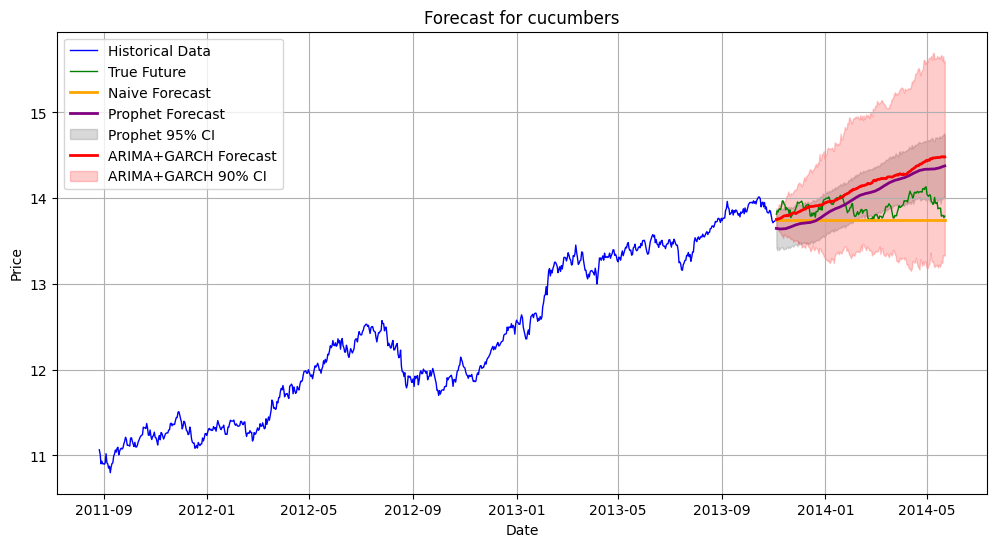

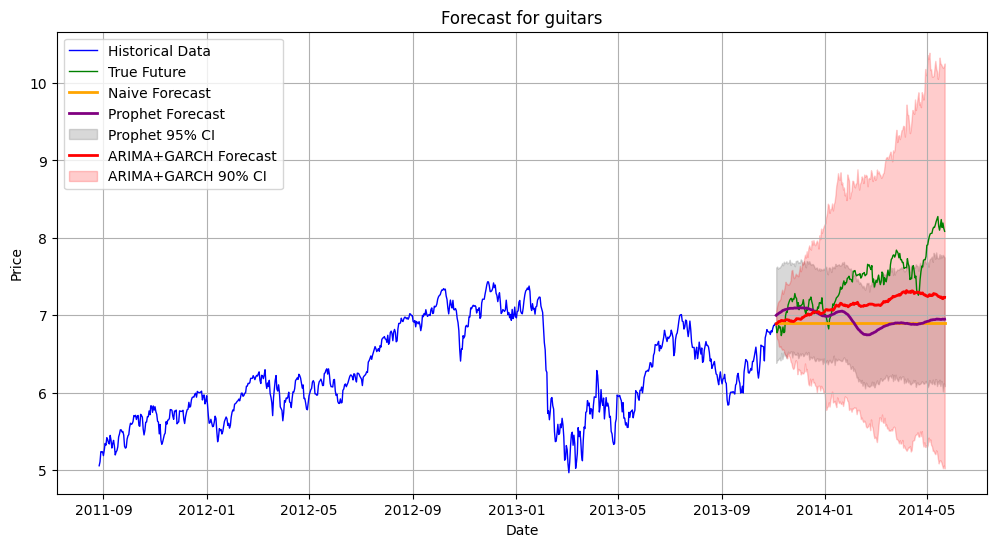

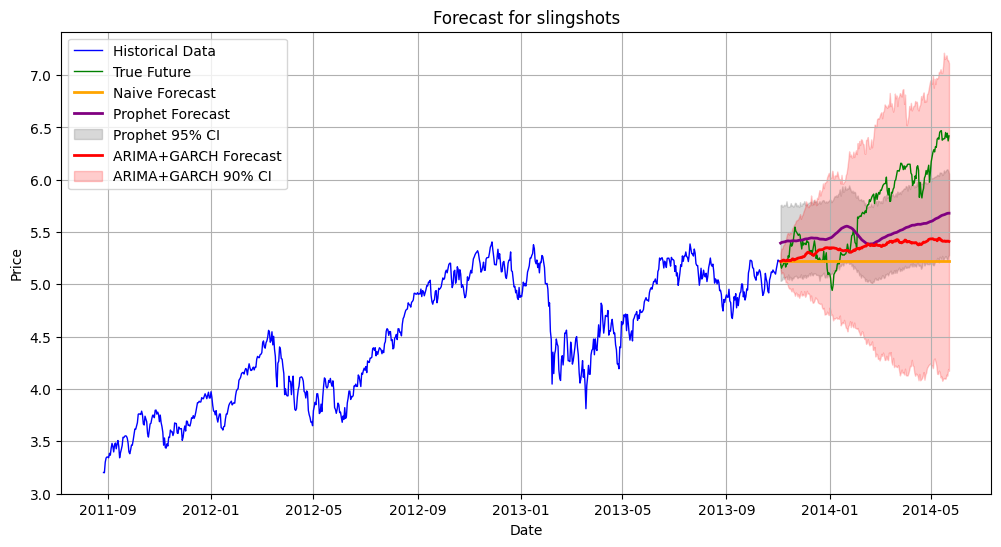

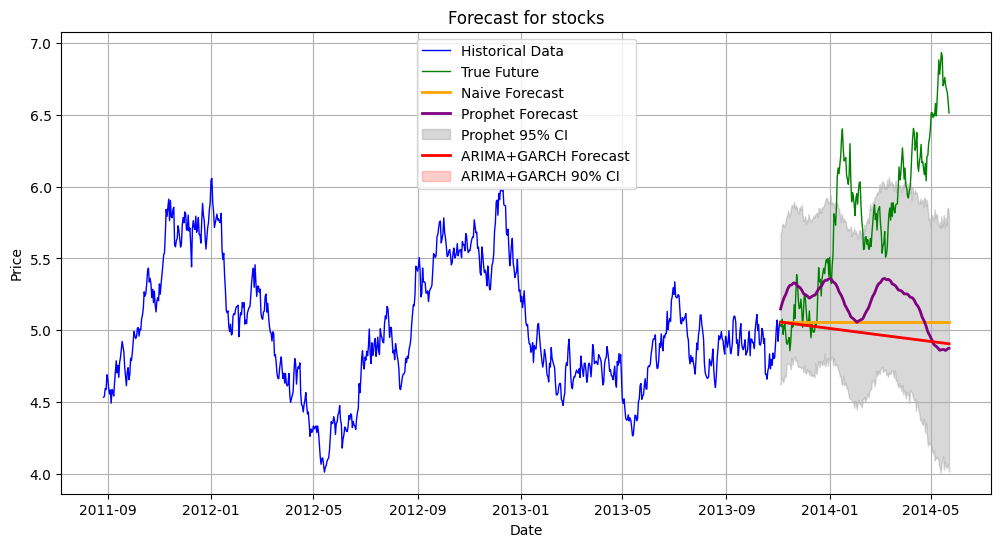

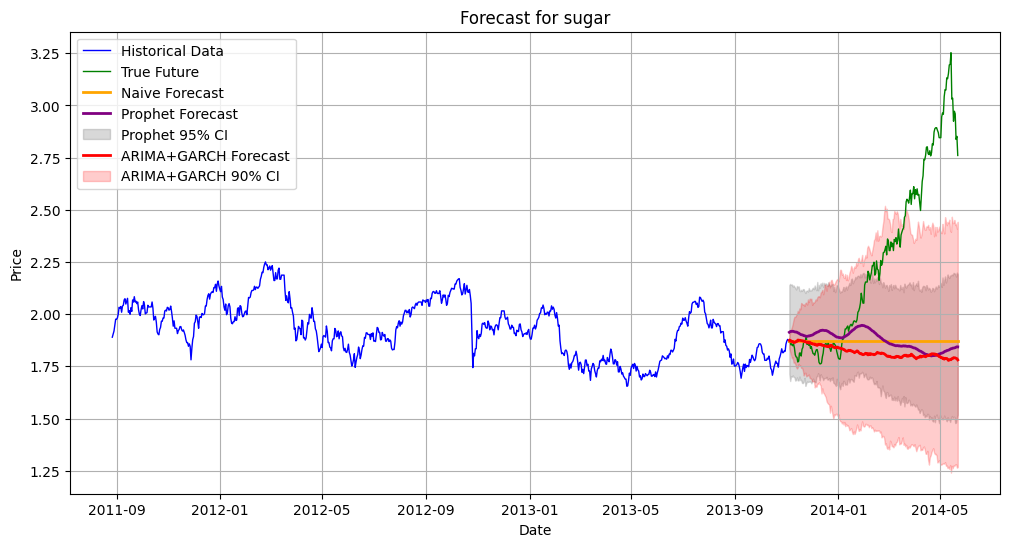

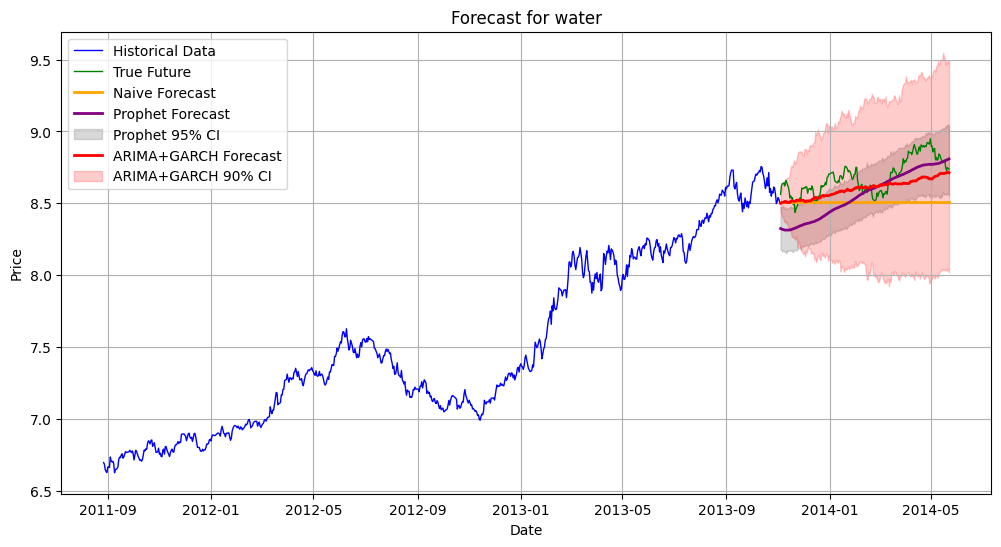

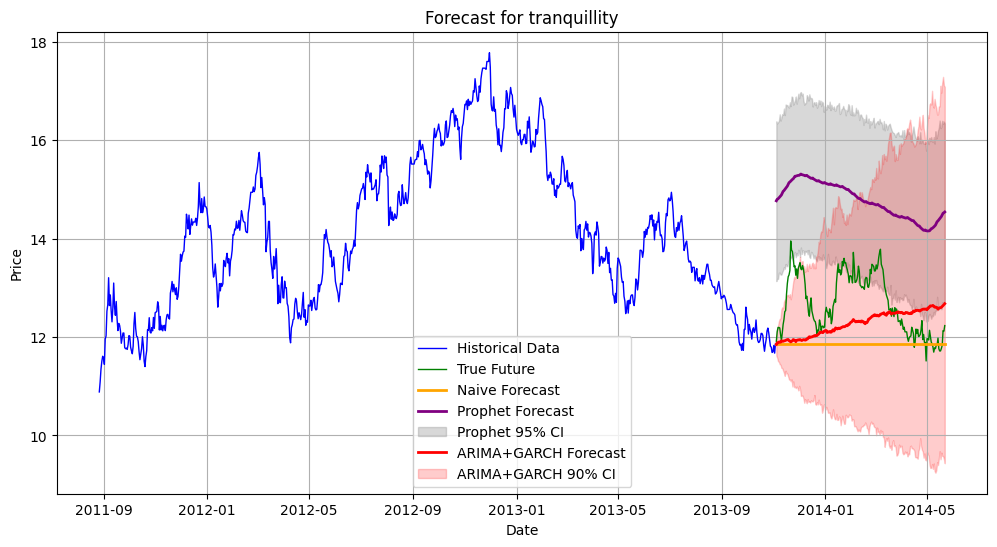

In [10]:
# Plot final forecasts with confidence intervals
for series_name in df_interpolated.columns:
    if series_name == 'day':
        continue

    # Extract historical and true future data
    train_data = df_interpolated[series_name][:-200]
    true_future = df_interpolated[series_name][-200:]

    # Generate dates for the forecast period
    last_train_date = train_data.index[-1]
    forecast_dates = pd.date_range(start=last_train_date + pd.Timedelta(days=1), periods=200, freq='D')

    # Extract forecasts for this series
    series_results = [r for r in results if r['series'] == series_name and 'final_forecast' in r]

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot historical data (last 800 points)
    plt.plot(train_data[-800:].index, train_data[-800:], label='Historical Data', color='blue', linewidth=1)

    # Plot true future data
    plt.plot(true_future.index, true_future, label='True Future', color='green', linewidth=1)

    # Plot forecasts for each model
    for result in series_results:
        model = result['model']
        forecast = result['final_forecast']

        if model == 'naive':
            plt.plot(forecast_dates, forecast, label='Naive Forecast', color='orange', linewidth=2)
        elif model == 'prophet':
            plt.plot(forecast_dates, forecast, label='Prophet Forecast', color='purple', linewidth=2)
            lower_bound = result['lower_bound']
            upper_bound = result['upper_bound']
            plt.fill_between(forecast_dates, lower_bound, upper_bound, color='gray', alpha=0.3, label='Prophet 95% CI')
        elif model == 'arima_garch':
            plt.plot(forecast_dates, forecast, label='ARIMA+GARCH Forecast', color='red', linewidth=2)
            lower_bound = result['lower_bound']
            upper_bound = result['upper_bound']
            plt.fill_between(forecast_dates, lower_bound, upper_bound, color='red', alpha=0.2, label='ARIMA+GARCH 90% CI')

    # Customize the plot
    plt.title(f'Forecast for {series_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

## Rolling window CV

TimeSeriesSplit is designed for time series CV. Ensures that the training set always preceds the test set, respect the temporal order of the data.

- n_splits = k, creates k folds each with a training set and a test set. The training set grows with each fold, and the tes set slides forward in time.

In our case:

5200 observations. (-1 from .diff()), splits = 5

- Training set size: Increases with each fold, calculated as:
  - Total number of observations is divided such that the last fold's test set ends the final observation
  - Training set size for each fold is determined by ensuring the test sets cover the last 5 * 200 = 1000 observations.

Splits are computed as:

Split 1:
- Train: Indices 0 to 4,199 (first 4,200 observations).
- Test: Indices 4,200 to 4,399 (next 200 observations).

Split 2:
- Train: Indices 0 to 4,399 (first 4,400 observations).
- Test: Indices 4,400 to 4,599 (next 200 observations).

Split 3:
- Train: Indices 0 to 4,599 (first 4,600 observations).
- Test: Indices 4,600 to 4,799 (next 200 observations).

Split 4:
- Train: Indices 0 to 4,799 (first 4,800 observations).
- Test: Indices 4,800 to 4,999 (next 200 observations).

Split 5:
- Train: Indices 0 to 4,999 (first 5,000 observations).
- Test: Indices 5,000 to 5,199 (last 200 observations).


## Calculation Details
- The test sets cover the last 1,000 observations (5 splits × 200 test observations).

- The first test set starts at index 5,199 - 1,000 = 4,199 (after the first 4,200 observations).

- Each subsequent test set shifts forward by 200 observations.

- The training set grows by 200 observations per fold, starting from 4,200 in the first fold to 5,000 in the last fold.


## Final Forecast:
In time series forecasting, CV is used for evaluation and model selection, but the final forecast typically uses the full dataset to maximize predictive power. This is especially important for long-horizon forecasts (our 200 steps), where small improvements in parameter estimates can compound over time.

# CV is not redundant

Rolling window CV is not redundant, even if we re-fit the model on the full dataset, because it serves a different purpose than the final forecast:

- CV Purpose: Evaluate and compare models (ARIMA + GARCH, baseline, Prophet) and validate parameter choices across multiple periods to ensure robustness and generalization.

- Final Forecast Purpose: Produce the most accurate 200-step-ahead predictions using all available data.

Without CV, we have no reliable way to:

- Compare ARIMA + GARCH against baseline or Prophet models.

- Assess whether the model generalizes across different periods of our data.

- Detect potential issues like overfitting or unstable parameter selection.



# IMRPOVEMENTS OF FORECAST

Instead of using all data which contains crashes, limit the data to stable periods, might better model the future.